##This notebook is for testing models.

In [ ]:
 #mount google drive with images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import datetime, os, cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from sklearn.metrics import classification_report, confusion_matrix

from google.colab.patches import cv2_imshow

In [ ]:
#https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759
#https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py maybe used?

#https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part3.ipynb

def create_model(hparams):

    #get the weights file, and load them onto an InceptionV3 model
    !wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
        -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
    local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    pre_trained_model = InceptionV3(
        input_shape=(150, 150, 3), include_top=False, weights=None)
    pre_trained_model.load_weights(local_weights_file)

    #lets make the model non-trainable, since we will only use it for feature extraction
    for layer in pre_trained_model.layers:
      layer.trainable = False

    #The layer we will use for feature extraction in Inception v3 is called mixed7. 
    #It is not the bottleneck of the network, but we are using it to keep a sufficiently 
    #large feature map (7x7 in this case). (Using the bottleneck layer would have 
    #resulting in a 3x3 feature map, which is a bit small.) Let's get the output from mixed7:
    
    last_layer = pre_trained_model.get_layer('mixed7')
    last_output = last_layer.output

    #Now let's stick a fully connected classifier on top of last_output:
    # Flatten the output layer to 1 dimension 
    x = layers.Flatten()(last_output)
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    # Add a dropout rate of 0.2
    x = layers.Dropout(.1)(x)
    # Add a final softmax layer for classification

    x = layers.Dense(1024, activation='relu')(x)

    x = layers.Dense(8, activation='softmax', name='visualized_layer')(x)

    #seems like this bit of code unfreezes layers after mixed6
    '''    
    unfreeze = False
    for layer in pre_trained_model.layers:
      if unfreeze:
        layer.trainable = True
      if layer.name == 'mixed6':
        unfreeze = True
    '''
    # Configure and compile the model
    model = Model(pre_trained_model.input, x)
    # Return pre-compiled model

    return model

In [ ]:
#load our best model from another notebook
loaded_model = create_model('blank')
loaded_model.load_weights("/content/drive/My Drive/machine_learning_projects/SupportClassification/eight_supports_balanced/weights_augmentation_study_unfreeze/weights.hdf5.ckpt")

--2020-07-03 23:31:21--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   135MB/s    in 0.6s    

2020-07-03 23:31:22 (135 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
#helper function to plot probability distribution across materials
def plot_class_distributions(preds):

    preds.tolist()

    target_names = ('Al$_2$O$_3$', 'CeO$_2$', 'MgO', 'NPs', 'POF', 'SiO$_2$-NBs', 'SiO$_2$-a', 'TiO$_2$')

    fig = plt.figure(figsize=(5.3,5.3))
    
    ax = fig.add_subplot(111)
    
    y_pos = np.arange(len(preds))
    plt.bar(y_pos, preds, color=[(.753, 0, 0, 1), (1, 0, 0, 1), (1, 1, 0, 1), (.573, .816, .314, 1), (0, .690, .314, 1), (0, .439, .753, 1), (0, .125, .376, 1), (.439, .188, .627, 1)])
    plt.yticks(fontsize = 14)
    ax.yaxis.tick_right()
    ax.set_ylabel('Predicted Class Probability', fontsize=14)
    ax.yaxis.set_label_position("right")    

    plt.xticks(y_pos, target_names, rotation = 90, fontsize = 14)

    plt.show()

In [ ]:
loaded_model.summary()
#use this to find last conv layer, and plug into next function for gradCAMs

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_846 (Conv2D)             (None, 74, 74, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_846 (BatchN (None, 74, 74, 32)   96          conv2d_846[0][0]                 
__________________________________________________________________________________________________
activation_846 (Activation)     (None, 74, 74, 32)   0           batch_normalization_846[0][0]    
___________________________________________________________________________________________

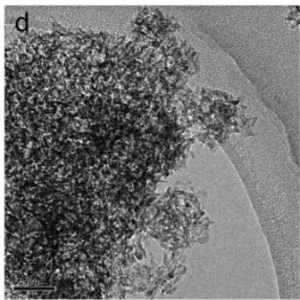

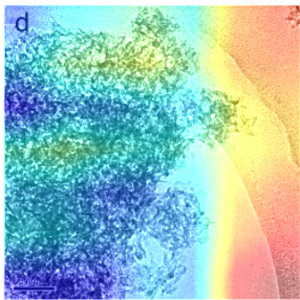

Predictions are [0.09775707 0.07823417 0.00415068 0.00281377 0.5492097  0.00628146
 0.25849324 0.00305988]


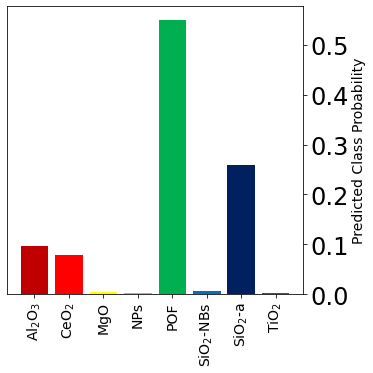

In [ ]:
#class activation map for material !!
def image_CAM(ORIGINAL):

    #load the original image
    #process to put it through the network
    img = image.load_img(ORIGINAL, target_size=(150, 150)) #load image as PIL.image.image
    x = image.img_to_array(img) #convert to numpy array (150, 150, 3)
    x = np.expand_dims(x, axis=0) #add that extra dimension (1, 150, 150, 3)
    #x = preprocess_input(x) #this it the preprocessing step used in the tutorial...
    x = x*1/255 #I hope this is the right preprocessing step... its what our image generator did

    preds = loaded_model.predict(x)

    with tf.GradientTape() as tape:
      last_conv_layer = loaded_model.get_layer('conv2d_915') #sometimes this changes?
      iterate = tf.keras.models.Model([loaded_model.inputs], [loaded_model.output, last_conv_layer.output])
      model_out, last_conv_layer = iterate(x)
      class_out = model_out[:, np.argmax(model_out[0])]
      grads = tape.gradient(class_out, last_conv_layer)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
      
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))

    #now show image with heatmap
    img = cv2.imread(ORIGINAL)
    img = cv2.resize(img, (300, 300)) 
    img_original = img                   # Resize image
    INTENSITY = 0.5
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    img = heatmap * INTENSITY + img
    cv2_imshow(img_original)
    cv2_imshow(img)

    print('Predictions are', preds[0])
    plot_class_distributions(preds[0])

##############################################################################
target_names = ['Al2O3', 'CeO2', 'MgO', 'NPs', 'POF', 'SiO2NBs-NBs', 'SiO2-a', 'TiO_2']
ORIGINAL = 'random_al2o3.jpg'

preds = image_CAM(ORIGINAL)

Found 800 images belonging to 8 classes.

 Confusion Matrix 
[[68  7  4  0  6  0 13  2]
 [ 4 85  6  0  1  0  3  1]
 [ 8  7 77  0  4  0  3  1]
 [ 0  0  2 98  0  0  0  0]
 [ 2  3  3  1 84  0  7  0]
 [ 0  1  5  2  0 92  0  0]
 [14  5  1  1 13  0 65  1]
 [ 9  5 21  0  0  0  5 60]] 

Classification Report
              precision    recall  f1-score   support

 Al$_2$O$_3$       0.65      0.68      0.66       100
     CeO$_2$       0.75      0.85      0.80       100
         MgO       0.65      0.77      0.70       100
         NPs       0.96      0.98      0.97       100
         POF       0.78      0.84      0.81       100
 SiO$_2$-NBs       1.00      0.92      0.96       100
   SiO$_2$-a       0.68      0.65      0.66       100
     TiO$_2$       0.92      0.60      0.73       100

    accuracy                           0.79       800
   macro avg       0.80      0.79      0.79       800
weighted avg       0.80      0.79      0.79       800

Class-balanced final accuracy is 78.625 percent

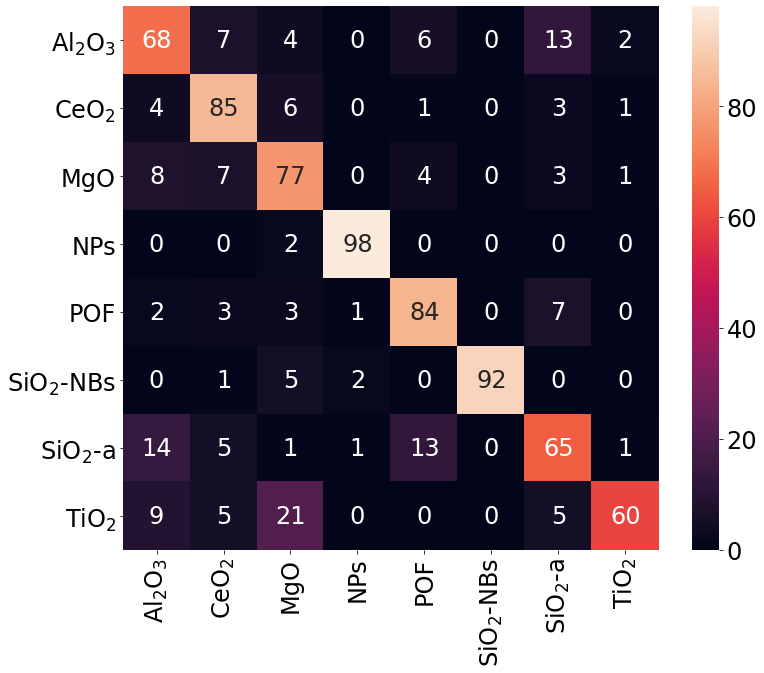

In [ ]:
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

#pull new validation data, that is unshuffled, for confusion matrix
batch_size = 800
IMG_HEIGHT = 150
IMG_WIDTH = 150

validation_dir = '/content/drive/My Drive/machine_learning_projects/SupportClassification/eight_supports_balanced/validation'

validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

val_data_gen = validation_image_generator.flow_from_directory(batch_size=800,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              shuffle = False)




target_names = ['Al$_2$O$_3$', 'CeO$_2$', 'MgO', 'NPs', 'POF', 'SiO$_2$-NBs', 'SiO$_2$-a', 'TiO$_2$']

Y_pred = loaded_model.predict_generator(val_data_gen, 1) #distribution between classes
y_pred = np.argmax(Y_pred, axis=1) #most likely class
print('\n', 'Confusion Matrix ')
conf_mat = confusion_matrix(val_data_gen.classes, y_pred)
print(conf_mat, '\n')
print('Classification Report')
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))


#beautiful confusion matrix as percentages with sklearn
row_sums = np.sum(conf_mat, axis = 1, keepdims = True)
conf_mat = np.round(conf_mat / row_sums * 100, 0)

df_cm = pd.DataFrame(conf_mat, index = [i for i in target_names],
                  columns = [i for i in target_names])
fig = plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True)
plt.rcParams.update({'font.size': 24})

final_acc = 0
for i in range(len(conf_mat)):
  final_acc += conf_mat[i,i]
final_acc /= 8
print('Class-balanced final accuracy is {} percent'.format(final_acc))